# Comparing two descriptors: SIFT, AKAZE

In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [3]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [11]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'image_name': image_name,'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    # print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics['thread_time'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
    
    metrics['matches_good_ratio'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics['localization_error_l1_mean'] = localization_errors_l1.mean()
    metrics['localization_error_l2_mean'] = localization_errors_l2.mean()

    
    #-- Localize the object
#     obj = np.empty((len(good_matches),2), dtype=np.float32)
#     scene = np.empty((len(good_matches),2), dtype=np.float32)

#     for i in range(len(good_matches)):
#         #-- Get the keypoints from the good matches
#         obj[i,0] = keypoints_image_kernel[good_matches[i].queryIdx].pt[0]
#         obj[i,1] = keypoints_image_kernel[good_matches[i].queryIdx].pt[1]
#         scene[i,0] = keypoints_image[good_matches[i].trainIdx].pt[0]
#         scene[i,1] = keypoints_image[good_matches[i].trainIdx].pt[1]
    
#     H, _ =  cv2.findHomography(obj, scene, cv2.RANSAC)
    
#     # print(type(H))
#     if H is None :
#         metrics['loc_error_norm_of_homography_matrix'] = 0
#     else:
#         metrics['loc_error_norm_of_homography_matrix'] = np.linalg.norm(H)
    
    return metrics, image_features, umat_to_mat(image_maches_draw)

In [10]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = []

    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
        os.mkdir(path_features)
        os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[1]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[2:]:

        metrics, image_features, image_maches_draw  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, ratio)
#         metrics_images[image_file_name] = metrics
        metrics_images.append(metrics)
        cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
        cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

In [12]:
descriptor_name='sift'
directory_train_name='test_lintroller'
json_dump_name='test_lintroller_sift'
name_directory_dump = 'test_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

kernel : /home/eduard/gitRepo/object_recognition/Lab2/test_lintroller/lintroller_1.jpg
sift
/home/eduard/gitRepo/object_recognition/Lab2/test_lintroller/lintroller_100.jpg


TypeError: descriptor 'get' requires a 'cv2.UMat' object but received a 'float'

In [ ]:
descriptor_name='akaze'
directory_train_name='test_lintroller'
json_dump_name='test_lintroller_akaze'
name_directory_dump = 'test_dump'

define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump)

# Working with metrics FOR FIRST OBJECT

In [20]:
file_name_json_sift = 'sandglass_train_dump/sandglass_sift.json'
file_name_json_akaze = 'sandglass_train_dump/sandglass_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [21]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,2.601966,0.058947,19.538328,894.555670
sandglass_101.jpg,0.75,1228800.0,0.198911,0.067368,27.893357,1581.075160
sandglass_102.jpg,0.75,1228800.0,0.210106,0.027368,23.338795,1073.034294
sandglass_103.jpg,0.75,3145728.0,0.546061,0.023158,24.119983,1184.231938
sandglass_104.jpg,0.75,1228800.0,0.197852,0.025263,27.031640,1457.254863
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,2.651926,0.037895,15.655334,582.194956
sandglass_79.jpg,0.75,16064064.0,2.639697,0.014737,13.742951,366.028911
sandglass_8.jpg,0.75,16064064.0,2.471395,0.037895,25.720951,1306.531401
sandglass_80.jpg,0.75,15996752.0,2.481429,0.025263,23.615181,1046.782228


In [22]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
sandglass_10.jpg,0.75,16064064.0,1.472541,0.076744,8.851163,154.525581
sandglass_101.jpg,0.75,1228800.0,0.142918,0.018605,7.130233,93.427907
sandglass_102.jpg,0.75,1228800.0,0.156566,0.020930,7.609302,110.288372
sandglass_103.jpg,0.75,3145728.0,0.325011,0.011628,7.655814,114.883721
sandglass_104.jpg,0.75,1228800.0,0.144284,0.027907,9.179070,158.746512
...,...,...,...,...,...,...
sandglass_78.jpg,0.75,16064064.0,1.609169,0.006977,5.106977,46.460465
sandglass_79.jpg,0.75,16064064.0,1.522646,0.006977,5.072093,50.583721
sandglass_8.jpg,0.75,16064064.0,1.516242,0.032558,8.790698,153.376744
sandglass_80.jpg,0.75,15996752.0,1.439198,0.027907,9.906977,186.851163


## Plots

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [23]:
def create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze):
    plt.plot(metrices_sift[feature_1], metrices_sift[feature_2], '-', color='red', label='SIFT')
    plt.plot(metrices_akaze[feature_1], metrices_akaze[feature_2], '-', color='blue', label='AKAZE')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    
    plt.legend()
    plt.show()
    plt.close()

In [24]:
def create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze):
    plt.plot(x_label, y_label_swift, '-', color='red', label='sift')
    plt.plot(x_label, y_label_akaze, '-', color='blue', label='akaze')
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.grid(True)
    plt.title(f'{feature_1} - {feature_2}')
    
    plt.legend()
    plt.show()
    plt.close()

### Pixels - time
- **red** collor - SIFT 
- **blue** collor - AKAZE

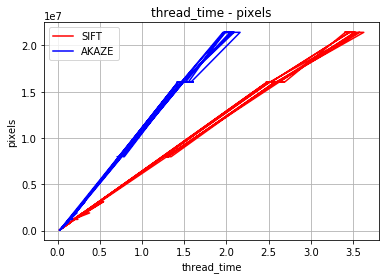

In [25]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

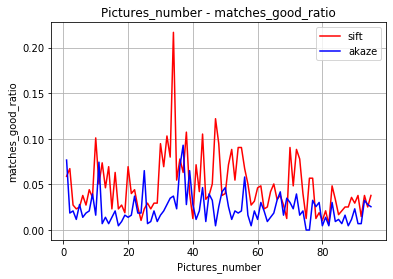

In [26]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

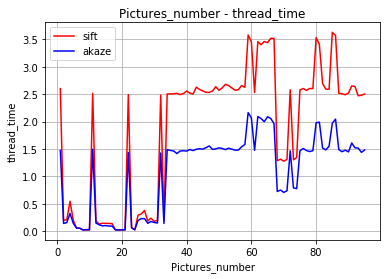

In [27]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

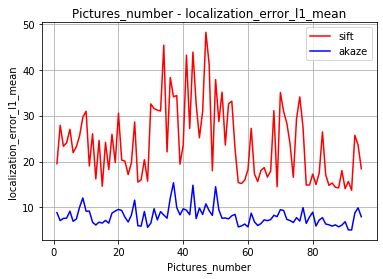

In [28]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

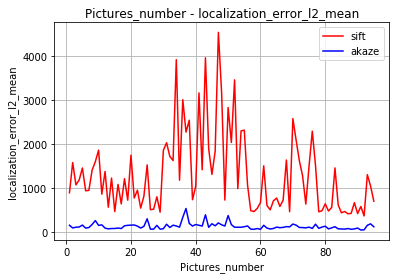

In [29]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

# Working with metrics FOR SECOND OBJECT

- **red** collor - SIFT 
- **blue** collor - AKAZE

In [30]:
file_name_json_sift = 'lintroller_train_dump/lintroller_sift.json'
file_name_json_akaze = 'lintroller_train_dump/lintroller_akaze.json'
metrices_sift = pd.read_json(file_name_json_sift)
metrices_akaze = pd.read_json(file_name_json_akaze)

metrices_sift = metrices_sift.T
metrices_akaze = metrices_akaze.T

In [31]:
metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_10.jpg,0.75,76800.0,0.025163,0.026172,20.671102,840.212672
lintroller_101.jpg,0.75,1228800.0,0.185953,0.010905,19.355810,722.003471
lintroller_102.jpg,0.75,1228800.0,0.173271,0.004362,19.319322,717.138334
lintroller_103.jpg,0.75,3145728.0,0.510898,0.021810,23.356073,1075.218720
lintroller_104.jpg,0.75,1228800.0,0.171848,0.009815,22.951896,957.533299
...,...,...,...,...,...,...
lintroller_78.jpg,0.75,307200.0,0.061536,0.007634,16.549763,527.779491
lintroller_79.jpg,0.75,1228800.0,0.190962,0.004362,13.961658,371.919386
lintroller_8.jpg,0.75,1228800.0,0.196756,0.007634,14.899421,453.012342
lintroller_80.jpg,0.75,921600.0,0.129327,0.017448,20.399958,804.349794


In [32]:
metrices_akaze

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_10.jpg,0.75,76800.0,0.029911,0.009091,8.745455,128.484848
lintroller_101.jpg,0.75,1228800.0,0.150611,0.009091,6.718182,88.730303
lintroller_102.jpg,0.75,1228800.0,0.157701,0.021212,7.706061,113.475758
lintroller_103.jpg,0.75,3145728.0,0.323945,0.003030,7.496970,109.066667
lintroller_104.jpg,0.75,1228800.0,0.168254,0.018182,8.790909,138.706061
...,...,...,...,...,...,...
lintroller_78.jpg,0.75,307200.0,0.064068,0.015152,7.654545,107.006061
lintroller_79.jpg,0.75,1228800.0,0.160879,0.006061,6.645455,83.203030
lintroller_8.jpg,0.75,1228800.0,0.166916,0.000000,6.318182,69.675758
lintroller_80.jpg,0.75,921600.0,0.121032,0.012121,8.778788,141.045455


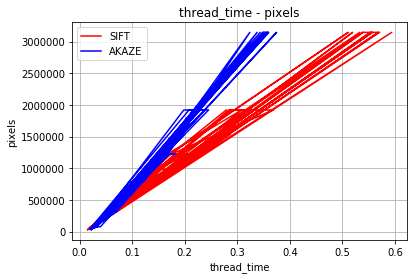

In [33]:
feature_1 = 'thread_time'
feature_2 = 'pixels'
create_curves_for_tabel(feature_1, feature_2, metrices_sift, metrices_akaze)

### Picture - matches_good_ratio
- **red** collor - SIFT 
- **blue** collor - AKAZE

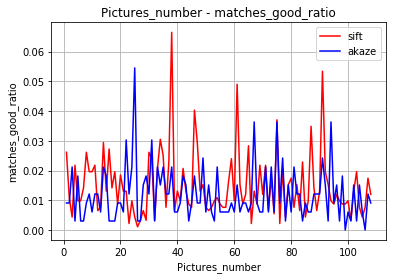

In [34]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['matches_good_ratio']
y_label_akaze = metrices_akaze['matches_good_ratio']

feature_1 = 'Pictures_number'
feature_2 = 'matches_good_ratio'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - thread_time
- **red** collor - SIFT 
- **blue** collor - AKAZE

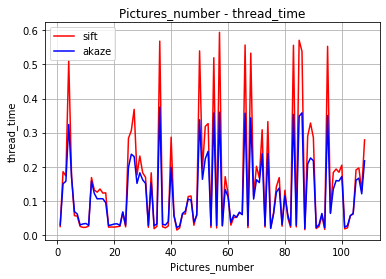

In [35]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['thread_time']
y_label_akaze = metrices_akaze['thread_time']

feature_1 = 'Pictures_number'
feature_2 = 'thread_time'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l1_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

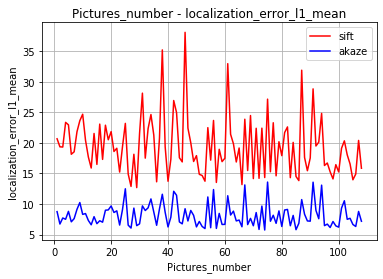

In [36]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l1_mean']
y_label_akaze = metrices_akaze['localization_error_l1_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l1_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

### Picture - localization_error_l2_mean
- **red** collor - SIFT 
- **blue** collor - AKAZE

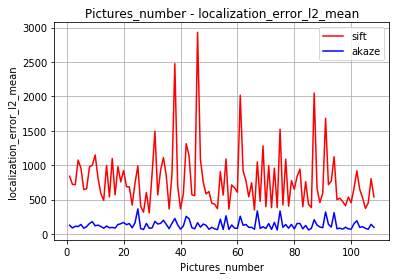

In [37]:
x_label = [x for x in range(1,metrices_sift.shape[0] + 1)]

y_label_swift = metrices_sift['localization_error_l2_mean']
y_label_akaze = metrices_akaze['localization_error_l2_mean']

feature_1 = 'Pictures_number'
feature_2 = 'localization_error_l2_mean'

create_curves_vectors(feature_1, feature_2, x_label, y_label_swift, y_label_akaze)

# TEST sets

In [22]:
lintroller_json_sift = 'test_dump/test_lintroller_sift.json'
lintroller_json_akaze = 'test_dump/test_lintroller_akaze.json'

lintroller_metrices_sift = pd.read_json(lintroller_json_sift)
lintroller_metrices_akaze = pd.read_json(lintroller_json_akaze)

lintroller_metrices_sift = lintroller_metrices_sift.T
lintroller_metrices_akaze = lintroller_metrices_akaze.T

In [23]:
sandglass_json_sift = 'test_dump/test_sandglass_sift.json'
sandglass_json_akaze = 'test_dump/test_sandglass_akaze.json'

sandglass_metrices_sift = pd.read_json(sandglass_json_sift)
sandglass_metrices_akaze = pd.read_json(sandglass_json_akaze)

sandglass_metrices_sift = sandglass_metrices_sift.T
sandglass_metrices_akaze = sandglass_metrices_akaze.T

## Read excel

In [24]:
lintroller_excel_test = 'excel_files/lintroller_test.xlsx'
sandglass_excel_test = 'excel_files/sandglass_test.xlsx'

lintroller_bool = pd.read_excel(lintroller_excel_test)
sandglass_bool = pd.read_excel(sandglass_excel_test)

lintroller_bool = lintroller_bool.sort_values(by=['Name'])
sandglass_bool = sandglass_bool.sort_values(by=['Name'])

In [26]:
print(len(lintroller_metrices_sift) == len(lintroller_bool))
print(len(lintroller_metrices_akaze) == len(lintroller_bool))
print(len(sandglass_metrices_sift) == len(sandglass_bool))
print(len(sandglass_metrices_akaze) == len(sandglass_bool))

True
True
True
True


In [27]:
lintroller_metrices_sift

,ratio,pixels,thread_time,matches_good_ratio,localization_error_l1_mean,localization_error_l2_mean
lintroller_100.jpg,0.75,983040.0,0.174988,0.019629,17.003141,577.539496
lintroller_131.jpg,0.75,76800.0,0.025324,0.020720,21.093363,838.015177
lintroller_132.jpg,0.75,76800.0,0.023718,0.038168,34.651307,2202.841015
lintroller_133.jpg,0.75,76800.0,0.023971,0.029444,24.703148,1196.868673
lintroller_134.jpg,0.75,76800.0,0.028504,0.014177,19.087922,674.691577
lintroller_135.jpg,0.75,76800.0,0.027050,0.021810,21.358561,847.918056
lintroller_136.jpg,0.75,76800.0,0.026565,0.013086,18.912697,645.309028
lintroller_137.jpg,0.75,76800.0,0.027173,0.005453,16.120643,494.467355
lintroller_138.jpg,0.75,76800.0,0.027036,0.023991,25.140628,1164.533690
lintroller_139.jpg,0.75,76800.0,0.027890,0.023991,21.456231,972.273149


In [28]:
lintroller_metrices_sift['bool'] = list(lintroller_bool['bool'])
sandglass_metrices_sift['bool'] = list(sandglass_bool['bool'])

lintroller_metrices_akaze['bool'] = list(lintroller_bool['bool'])
sandglass_metrices_akaze['bool'] = list(sandglass_bool['bool'])

In [29]:
def create_curves_vectors_bool(metrics_sift, metrics_akaze, feature, title, bool_=1):
    
    feature_sift = list(metrics_sift[metrics_sift['bool'] == bool_][feature])
    feature_akaze = list(metrics_akaze[metrics_akaze['bool'] == bool_][feature])
    
    x_label = [x for x in range(len(feature_sift))]
    
    plt.plot(x_label, feature_sift, '-', color='red', label=f'{feature}_sift')
    plt.plot(x_label, feature_akaze, '-', color='blue', label=f'{feature}_akaze')
    
    plt.xlabel('images')
    plt.ylabel(feature)
    plt.grid(True)
    plt.title(f'{title}_{feature}_bool={bool_}')
    
    plt.legend()
    plt.show()
    plt.close()

## Comparing feature values between AKAZE and SIFT by lintroller_test_set

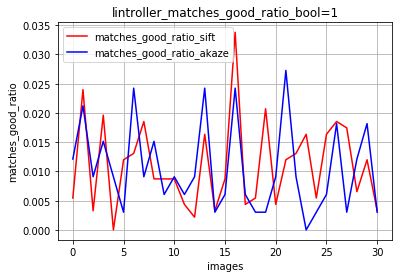

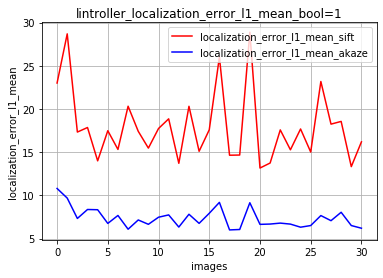

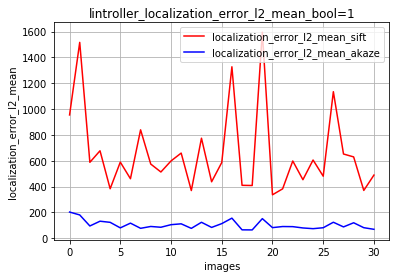

In [30]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'lintroller'
bool_my = 1

for feature in features:
    create_curves_vectors_bool(lintroller_metrices_sift, lintroller_metrices_akaze, feature, title, bool_my)

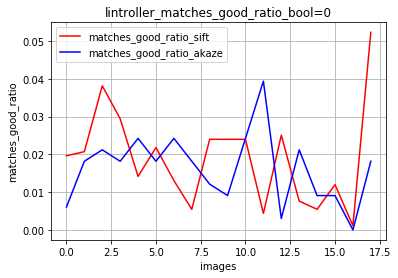

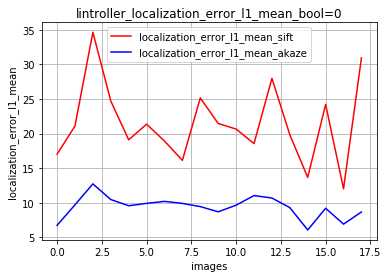

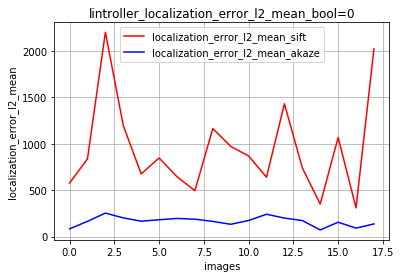

In [31]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'lintroller'
bool_my = 0

for feature in features:
    create_curves_vectors_bool(lintroller_metrices_sift, lintroller_metrices_akaze, feature, title, bool_my)

## Comparing feature values between AKAZE and SIFT by sandglass_test_set

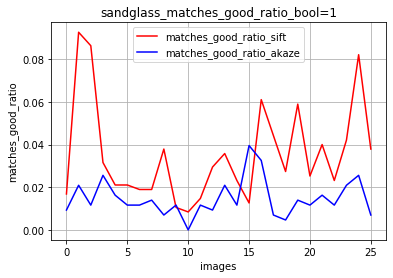

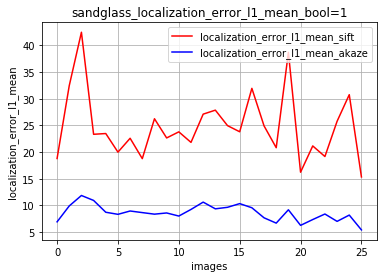

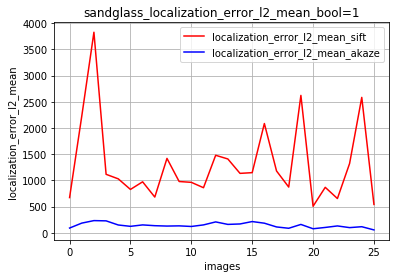

In [32]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'sandglass'
bool_my = 1

for feature in features:
    create_curves_vectors_bool(sandglass_metrices_sift, sandglass_metrices_akaze, feature, title, bool_my)

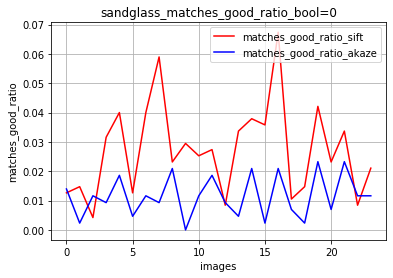

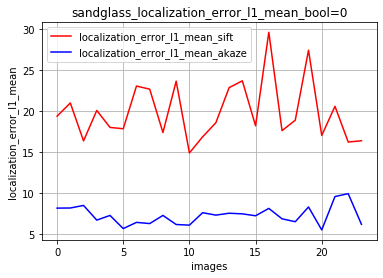

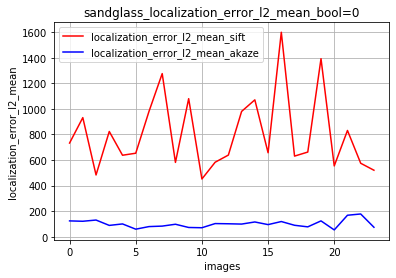

In [33]:
features = ['matches_good_ratio', 'localization_error_l1_mean', 'localization_error_l2_mean']
title = 'sandglass'
bool_my = 0

for feature in features:
    create_curves_vectors_bool(sandglass_metrices_sift, sandglass_metrices_akaze, feature, title, bool_my)

# Conclusions